# Snake

In [1]:
from snake import re_normalize_possible_actions
from environments import *
import tensorflow as tf
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
from itertools import islice

## Environment definition

In [2]:
BOARD_SIZE=3

In [3]:
# region models
input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(32, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.GlobalAvgPool2D()(x)

encoder = K.Model(inputs=input, outputs=x)

dec = K.layers.Reshape((1, 1, -1))(x)
dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
if BOARD_SIZE > 3:
    dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
if BOARD_SIZE > 4:
    dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.Conv2DTranspose(3, 2, activation=tf.nn.softmax)(dec)
decoder = K.Model(inputs=x, outputs=dec)

ae = K.models.Sequential([
    encoder,
    decoder
])

policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)

# value = K.models.Sequential()
# value.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(1, activation='linear'))
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

Metal device set to: Apple M1 Max


2022-12-24 02:06:52.924686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-24 02:06:52.924872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
#value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")

## Training

In [5]:
env_ = NumpyEnvironment(1000, BOARD_SIZE)
GAMMA = .99
ITERATIONS = 10000

In [6]:
agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
ae.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")

In [7]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-4)
optimizer_autoencoder= K.optimizers.Adam(1e-4)

In [8]:
avg_rewards = []
ae_losses = []

for iterations in trange(ITERATIONS):
    state = env_.to_state()

    if iterations % 10 == 0:
        agent.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
        value.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
        ae.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")
    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions
        original_probs = agent(
            state
        )
        # remove actions that are not available
        probs = re_normalize_possible_actions(
            state,
            original_probs
        )
        # sample actions
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        # print("start move")
        rewards = env_.move(actions)
        # print("end move")
        new_state = env_.to_state()

        # TD error
        value_state = value(state)
        td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1  # to do gradient ascend

        # calculate the loss for both value and agent
        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)

        # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
        loss_agent = tf.stop_gradient(td_error) * tf.math.log(tf.gather_nd(probs, actions_indexes))
        loss_value = tf.stop_gradient(td_error) * value_state
        rec = ae(state)
        loss = tf.reduce_sum(K.losses.CategoricalCrossentropy()(state, rec))
    ae_losses.append(loss)
    grad = tape.gradient(loss, ae.trainable_weights)
    optimizer_autoencoder.apply_gradients(zip(grad, ae.trainable_weights))

    # calculate gradient
    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)
    avg_rewards.append(tf.reduce_mean(rewards))

    # update neural nets weights
    optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
    optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))


 23%|██▎       | 2323/10000 [02:58<10:17, 12.44it/s]

won


 23%|██▎       | 2335/10000 [02:59<10:00, 12.75it/s]

won


 26%|██▌       | 2555/10000 [03:15<08:46, 14.14it/s]

won


 51%|█████▏    | 5129/10000 [06:32<05:49, 13.95it/s]

won


 55%|█████▌    | 5537/10000 [07:03<05:16, 14.09it/s]

won


 57%|█████▋    | 5725/10000 [07:17<05:09, 13.83it/s]

won


 59%|█████▉    | 5903/10000 [07:30<05:23, 12.66it/s]

won


 66%|██████▋   | 6649/10000 [08:29<03:55, 14.23it/s]

won


 72%|███████▏  | 7217/10000 [09:14<03:30, 13.25it/s]

won


 86%|████████▌ | 8575/10000 [10:56<01:41, 14.06it/s]

won


 99%|█████████▉| 9939/10000 [12:38<00:04, 14.21it/s]

won


 99%|█████████▉| 9949/10000 [12:39<00:03, 14.34it/s]

won


100%|██████████| 10000/10000 [12:43<00:00, 13.10it/s]


   ### Random policy reward

In [17]:
random_env_ = NumpyEnvironment(1000, BOARD_SIZE)
random_rewards = []

for _ in trange(1000):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],1000, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 1000/1000 [00:14<00:00, 68.11it/s]


## Training evaluation

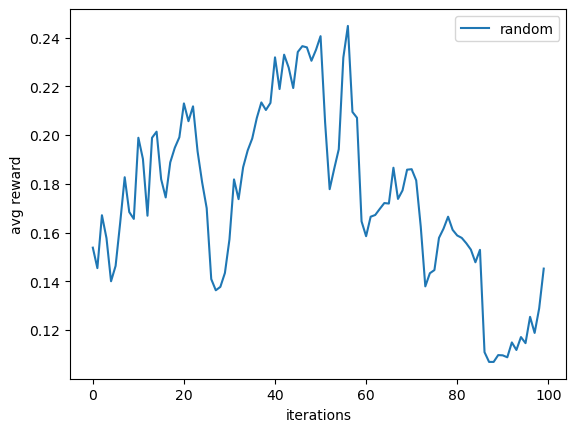

In [15]:
%matplotlib inline
#plt.plot(np.array(random_rewards).reshape((-1, 10)).mean(axis=-1))

plt.plot(np.clip(np.array(avg_rewards).reshape((-1, 100)), -1, 0.4).mean(axis=-1))
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [25]:
test_env = NumpyEnvironment(10,BOARD_SIZE)

In [26]:
def animate(_):
    state = test_env.to_state()
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    log_probs = tf.math.log(tf.stop_gradient(probs))
    actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [27]:
fig, axs = plt.subplots(2,5)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, frames=3,interval=10)

<IPython.core.display.Javascript object>